# Determinação de Impedimento

Para executar o código basta rodar as células sequencialmente. Em linhas gerais o algoritmo do presente notebook implementa a identificação dos jogadores, seus times e keypoints, além da determinação do ponto de fuga da imagem que permite então o traçado das possíveis linhas de impedimento. O código é suposto rodar em um Colab ou ambiente computacional com GPU.

Além disso, para testar o código você vai precisar das imagens de impedimento que se encontram no arquivo zip que continha o presente notebook.

In [9]:
# # Descomente o presente código se você já fez o upload do arquivo images.zip para o Colab:
# !jar xvf images.zip

  created: images/
 inflated: images/.DS_Store
 inflated: images/0.jpg
 inflated: images/1.jpg
 inflated: images/10.jpg
 inflated: images/100.jpg
 inflated: images/101.jpg
 inflated: images/102.jpg
 inflated: images/103.jpg
 inflated: images/104.jpg
 inflated: images/105.jpg
 inflated: images/106.jpg
 inflated: images/107.jpg
 inflated: images/108.jpg
 inflated: images/109.jpg
 inflated: images/11.jpg
 inflated: images/110.jpg
 inflated: images/111.jpg
 inflated: images/112.jpg
 inflated: images/113.jpg
 inflated: images/114.jpg
 inflated: images/115.jpg
 inflated: images/116.jpg
 inflated: images/117.jpg
 inflated: images/118.jpg
 inflated: images/119.jpg
 inflated: images/12.jpg
 inflated: images/120.jpg
 inflated: images/121.jpg
 inflated: images/122.jpg
 inflated: images/123.jpg
 inflated: images/124.jpg
 inflated: images/125.jpg
 inflated: images/126.jpg
 inflated: images/127.jpg
 inflated: images/128.jpg
 inflated: images/129.jpg
 inflated: images/13.jpg
 inflated: images/130.jpg

Inicializações gerais:

In [10]:
!pip install pyyaml==6.0
!pip install Pillow
!pip install google-colab

# DETECTRON 2 SETUP
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

fatal: destination path 'detectron2' already exists and is not an empty directory.


In [11]:
# Import some common libraries
import numpy as np
import json, cv2, re
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from collections import Counter
from scipy.optimize import minimize


# Import clustering models
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture

# Import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [14]:
class PlayersClassification:

    def __init__(self):
        '''
        Initializes the panoptic and keypoints model from Detectron2
        '''
        # Using panoptic segmentation to get field area
        cfg = get_cfg()
        cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
        self.panoptic_pred = DefaultPredictor(cfg)
        self.cfg = cfg

        # keypoint detection model
        cfg_keypoint = get_cfg()   # get a fresh new config
        cfg_keypoint.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
        cfg_keypoint.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
        cfg_keypoint.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
        self.keypoint_pred = DefaultPredictor(cfg_keypoint)

    def get_image_info(self, file_name):
        '''
        file_name: image filename
        return: image_info object that contains information about player keypoints and teams
        '''
        image_info = {
            'players': get_people_keypoints(cv2.imread(file_name), self.cfg, self.panoptic_pred, self.keypoint_pred),
            'file_name': file_name
        }

        field_players_dict, field_players_id, other_players_id = classify_teams(image_info)

        for id in field_players_id:
            image_info['players'][id]['team'] = f'Team{field_players_dict[id]+1}'
        for id in other_players_id:
            image_info['players'][id]['team'] = 'GK'

        return image_info

    def get_image(self, image_info):
        '''
        image_info: image_info dictionary obtained by get_image_info()

        plots the image with all keypoints and teams classified
        Blue: Team1
        Green: Team2
        Others (GK category): Red
        '''
        im = cv2.imread(image_info['file_name'])
        for player in image_info['players']:
            if player['team'] == 'Team1':
                color = (255, 0, 0) # Blue
            elif player['team'] == 'Team2':
                color = (0, 255, 0) # Green
            else:
                color = (0, 0, 255) # Red
            for keypoint in player['keypoints']:
                x, y = keypoint
                x = round(x)
                y = round(y)
                im = cv2.circle(im, center=(x,y), color=color, radius=5, thickness=-1)

        return im

def remove_blobs(mask):
    '''
    mask: imagem com um canal de cor. O valor desse canal é:
        255 se for região de campo
        0 se não for campo

    A função retorna uma mask modificada removendo blobs indesejados detectados originalmente como campo
    '''
    mask_with_border = mask.copy()
    height, width = mask.shape

    #Create a board for the image
    for y in range(height):
        mask_with_border[y,0] = 0
        mask_with_border[y,-1] = 0
    for x in range(width):
        mask_with_border[0,x] = 0
        mask_with_border[-1,x] = 0

    contours, _ = cv2.findContours(mask_with_border, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate areas of blobs
    areas = [cv2.contourArea(cnt) for cnt in contours]

    # Find the index of the largest blob
    max_index = np.argmax(areas)

    # Create a binary mask
    result = np.zeros_like(mask)
    cv2.drawContours(result, contours, max_index, 255, thickness=cv2.FILLED)

    return result

def isolate_field(image, panoptic_cfg, panoptic_predictor):
    '''
    image: cv2 image object
    panoptic_cfg: panoptic_predictor cfg object
    panoptic_predictor: a panoptic predictor model from detectron2

    This function returns a image without the game audience
    '''
    panoptic_seg, segments_info = panoptic_predictor(image)["panoptic_seg"]
    v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(panoptic_cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
    max_person_area = 0

    for info in segments_info:
        if(info['category_id'] == 18): # playing field
            field_id = info['id']

        if(info['category_id'] == 0):  # person
            max_person_area = max(max_person_area, info['area'])

    dilate_size = round(np.sqrt(max_person_area)*2)
    erode_size = round(np.sqrt(max_person_area)/2)

    dilate_box = np.ones((dilate_size, dilate_size))
    erode_box = np.ones((erode_size, erode_size))


    field_mask = np.where(np.array(panoptic_seg.cpu()) == field_id, 255, 0)
    field_mask = np.array(field_mask, np.uint8)
    field_mask = cv2.erode(field_mask, erode_box)
    field_mask = cv2.dilate(field_mask, dilate_box)
    field_mask = remove_blobs(field_mask)

    edited_image = image.copy()
    edited_image[field_mask == 0] = 0

    return edited_image

def get_people_keypoints(image, panoptic_cfg, panoptic_predictor, keypoint_predictor):
    '''
    image: cv2 image object
    panoptic_cfg: panoptic_predictor cfg object
    panoptic_predictor: a panoptic predictor model from detectron2
    keypoint_predictor: a person keypoint predictor model from detectron2

    This function returns the keypoints of all the players in the field
    '''

    outputs = keypoint_predictor(isolate_field(image, panoptic_cfg, panoptic_predictor))

    people = []

    # Iterate through keypoints and add them to list
    keypoints = outputs["instances"].pred_keypoints.cpu()
    for i, instance_keypoints in enumerate(keypoints):
        person_info = dict()
        person_info['keypoints'] = np.concatenate((instance_keypoints[0:1,:2], instance_keypoints[5:6,:2],
                                            instance_keypoints[11:12,:2], instance_keypoints[13:14,:2],
                                            instance_keypoints[15:,:2], instance_keypoints[14:15,:2],
                                            instance_keypoints[12:13,:2],instance_keypoints[6:7,:2]), axis=0).tolist()
        person_info['player_id'] = i
        people.append(person_info)

    return people

def get_mean_color(image, points: np.array):
    '''
    image: cv2 image object
    points: (N,2) array of points

    returns the mean color in the polygonal region delimited by the points
    '''
    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.fillPoly(mask, np.int32([points]), 255)
    mean_color = cv2.mean(image, mask=mask)[:-1]
    return mean_color

def color_amplify(color_array):
    '''
    color_array: array of BGR colors to be transformed

    returns a modified array of BGR colors.
    The modification involves amplifying the difference between the bigger and the lower BGR component.
    This way, visually similar colors will have small euclidean distance.
    '''

    sum_colors = np.sum(color_array, axis = 1)[:, None]
    normalized = color_array/sum_colors
    transformer = np.exp(2*normalized) - 1
    transformed = normalized*transformer
    normalized_transformed = transformed/np.sum(transformed, axis = 1)[:, None]

    return np.clip(normalized_transformed * sum_colors, 0, 255)

def cluster_teams(image_info, eps = 55):
    '''
    image_info: dictionary in image_info format
    eps: eps for the gaussian model
    return: list of all classifications

    Uses the DBSCAN clustering model to segregate field players (team1 and 2) and
    other persons (GK, referees and possibly unidentified people)
    '''
    image = cv2.imread(image_info['file_name'])
    average_colors = []

    for player in image_info['players']:
        keypoints = player['keypoints']
        points = np.array([keypoints[1], keypoints[2], keypoints[7], keypoints[8]])
        average_colors.append(get_mean_color(image, points))

    db = DBSCAN(eps=eps, min_samples=1)
    db.fit(color_amplify(np.array(average_colors)))
    return list(db.labels_)

def get_teams(labels):
    '''
    labels: list from clustes_teams function

    returns the labels corresponding to team1 and team2
    '''
    counter = Counter(labels)
    team1 = max(counter, key=counter.get)
    counter.pop(team1)
    team2 = max(counter, key=counter.get)

    return team1, team2

def segregate_field_players(image_info):
    '''
    image_info: dictionary in image_info format

    returns two lists:
    1) list of all field players
    2) list of all other persons (GK, referees and unidentified persons)
    '''
    clusters = cluster_teams(image_info)
    team1, team2 = get_teams(clusters)

    return [player for player in image_info['players'] if clusters[player['player_id']] in (team1, team2)], [player for player in image_info['players'] if clusters[player['player_id']] not in (team1, team2)]

def lab_transform(color_array):
    '''
    transform an array of BGR colors to an array of colors in LAB format
    '''
    reshaped_array = np.uint8(color_array.reshape(-1, 1, 3))
    return cv2.cvtColor(reshaped_array, cv2.COLOR_BGR2LAB).reshape(-1, 3)

def classify_teams(image_info):
    '''
    image_info: dictionary in image_info format

    returns a dictionary and two lists:
    1) dictionary associating the field player id and its team
    2) id of all field players
    3) id of all other persons (GK, referees and unidentified persons)

    The id of a person is its index in image_info['players']
    '''
    field_players, other_players = segregate_field_players(image_info)
    n_samples = len(field_players)
    image = cv2.imread(image_info['file_name'])
    field_player_colors = []
    for player in field_players:
        keypoints = player['keypoints']
        points = np.array([keypoints[1], keypoints[2], keypoints[7], keypoints[8]])
        field_player_colors.append(get_mean_color(image, points))

    field_lab_colors = lab_transform(np.array(field_player_colors))
    gaussian_model = GaussianMixture(n_components=2, random_state=0)
    gaussian_model.fit(field_lab_colors)
    field_players_result = gaussian_model.predict(field_lab_colors)

    field_players_id = [player['player_id'] for player in field_players]
    other_players_id = [player['player_id'] for player in other_players]

    field_players_dict = dict(zip(field_players_id, field_players_result))

    return field_players_dict, field_players_id, other_players_id


def example(image):
  model = PlayersClassification()
  im_info = model.get_image_info(image)
  im = model.get_image(im_info)

  output = './output/output.png'

  cv2_imshow(im)
  cv2.imwrite(output, im)

### Identificação dos jogadores, times e keypoints

Para testar, basta rodar a célula abaixo, que gera uma lista de todos jogadores identificados atribuindo a eles keypoints, um id e o time.

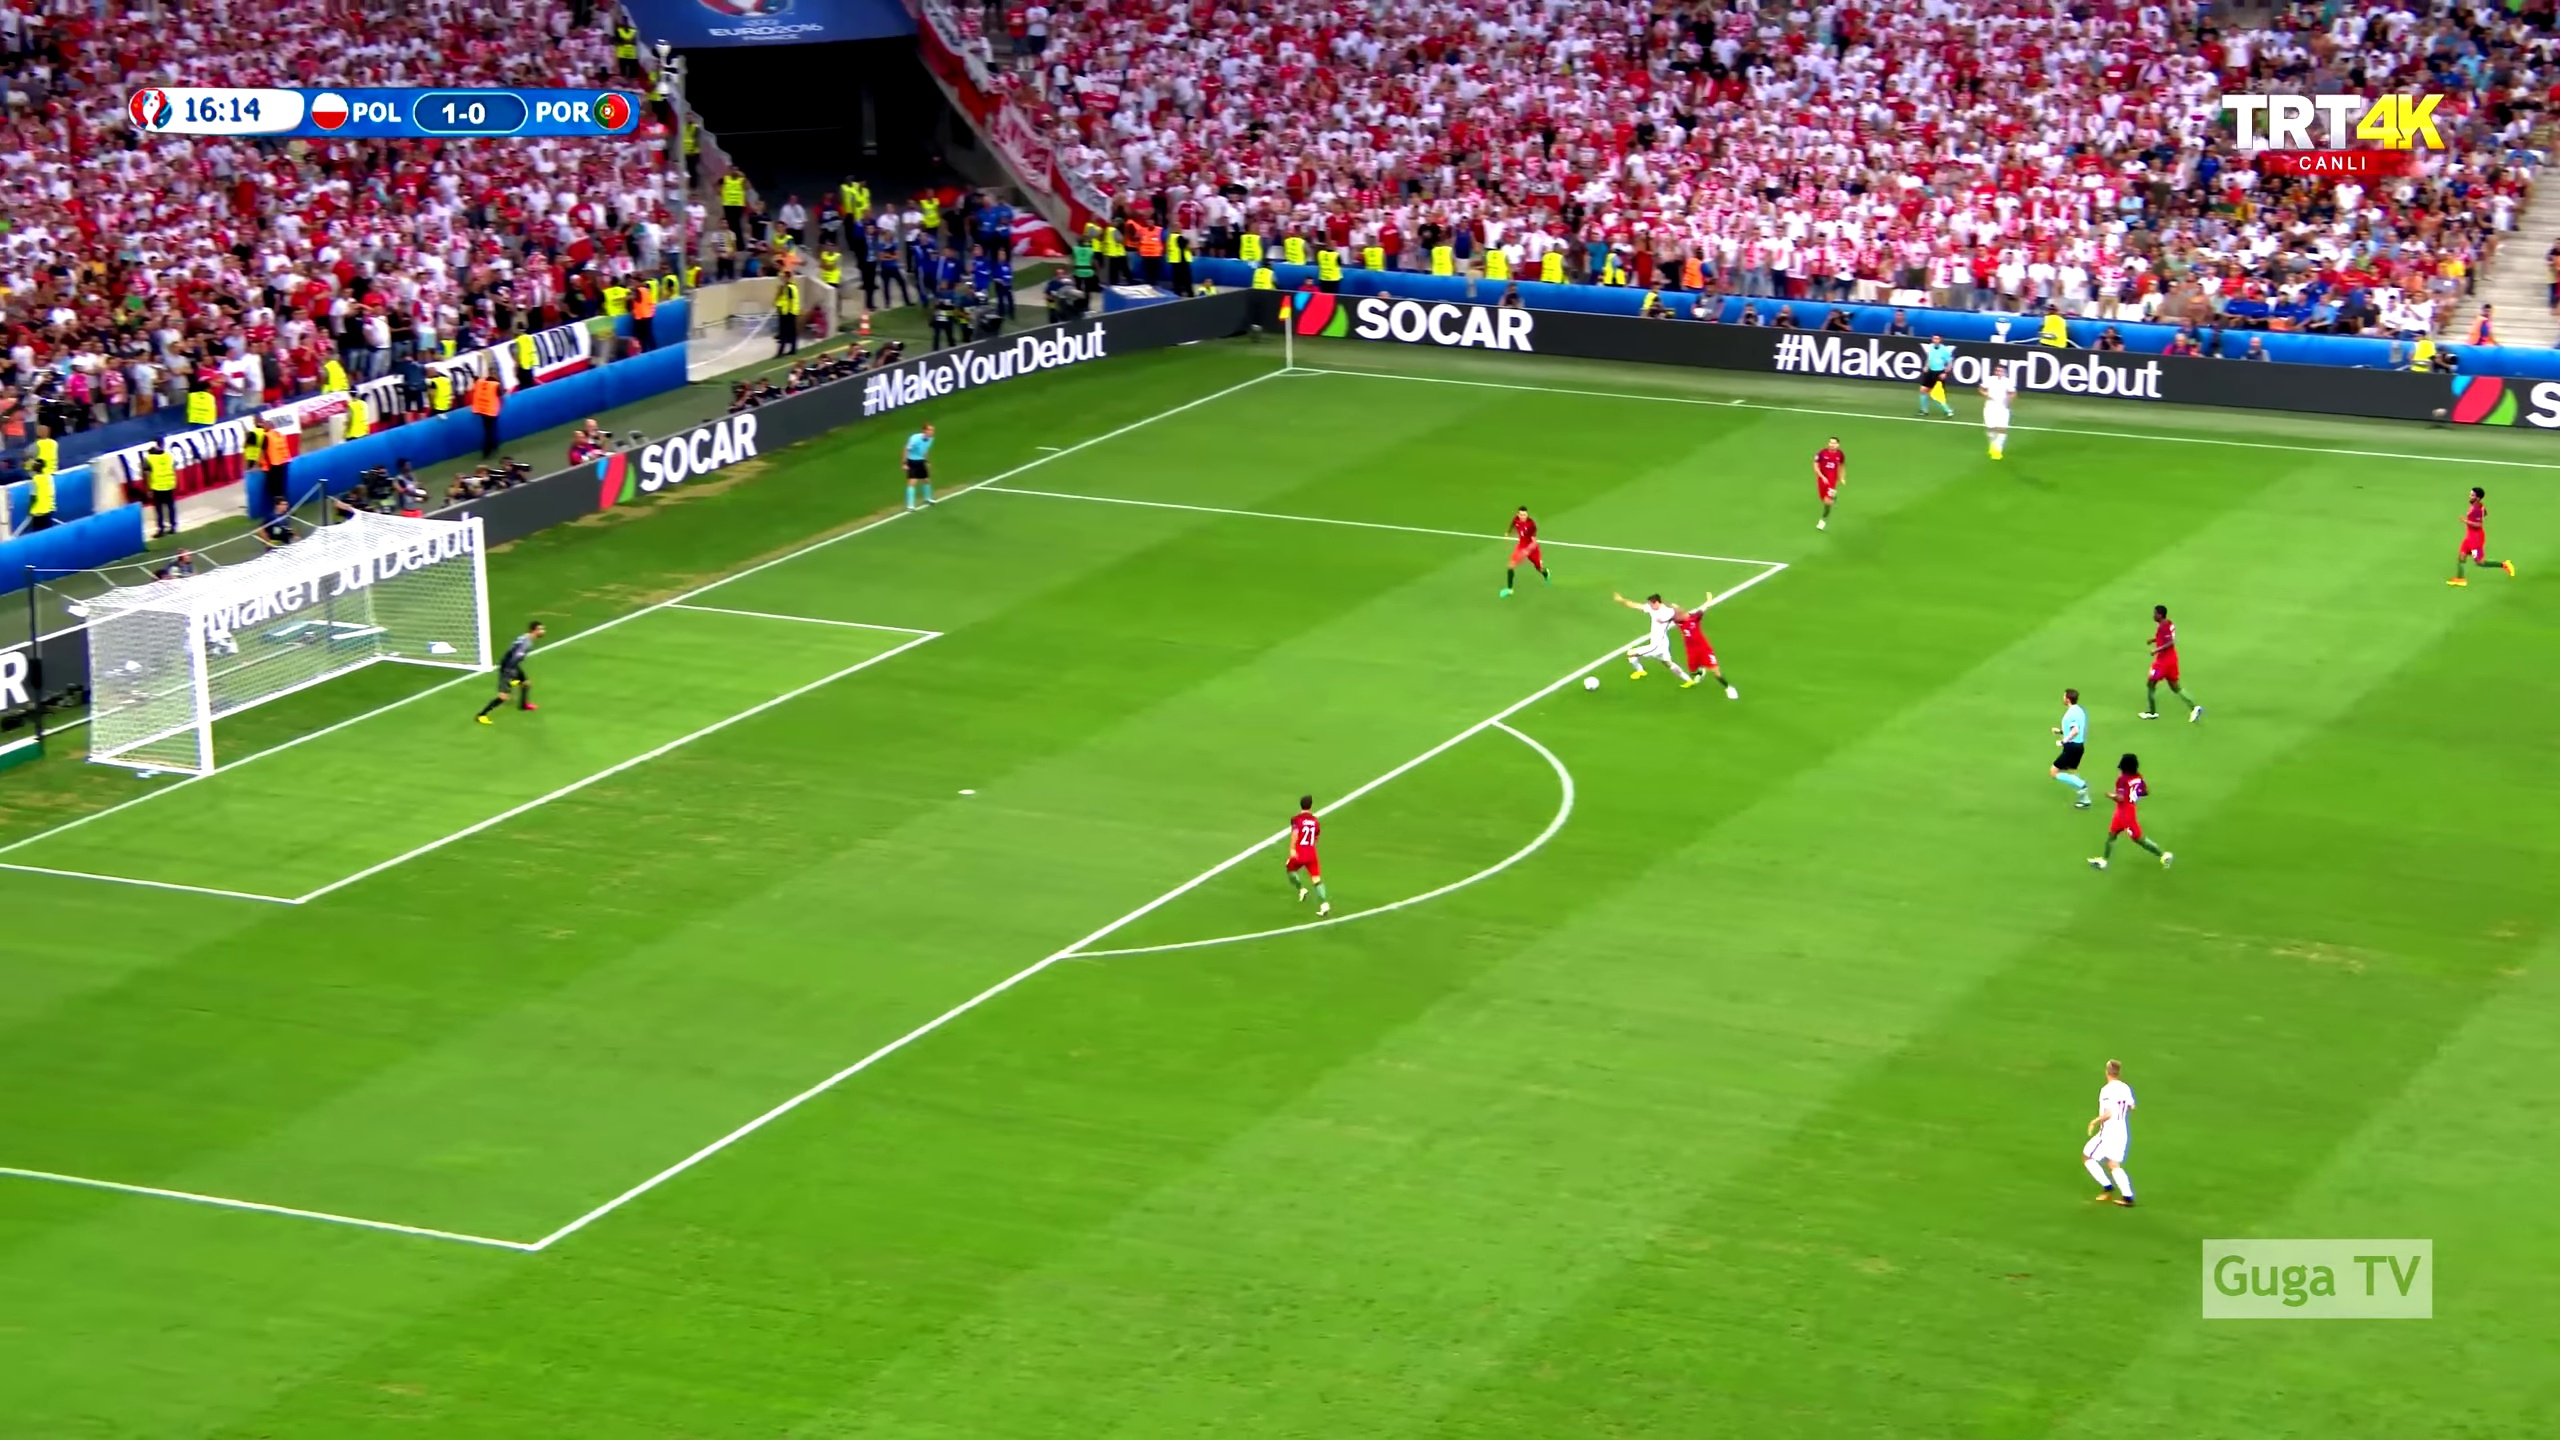

In [49]:
# Testing the players_classification
images = './images'
image_path = images + '/1.jpg'
image = cv2.imread(image_path)
cv2_imshow(image)

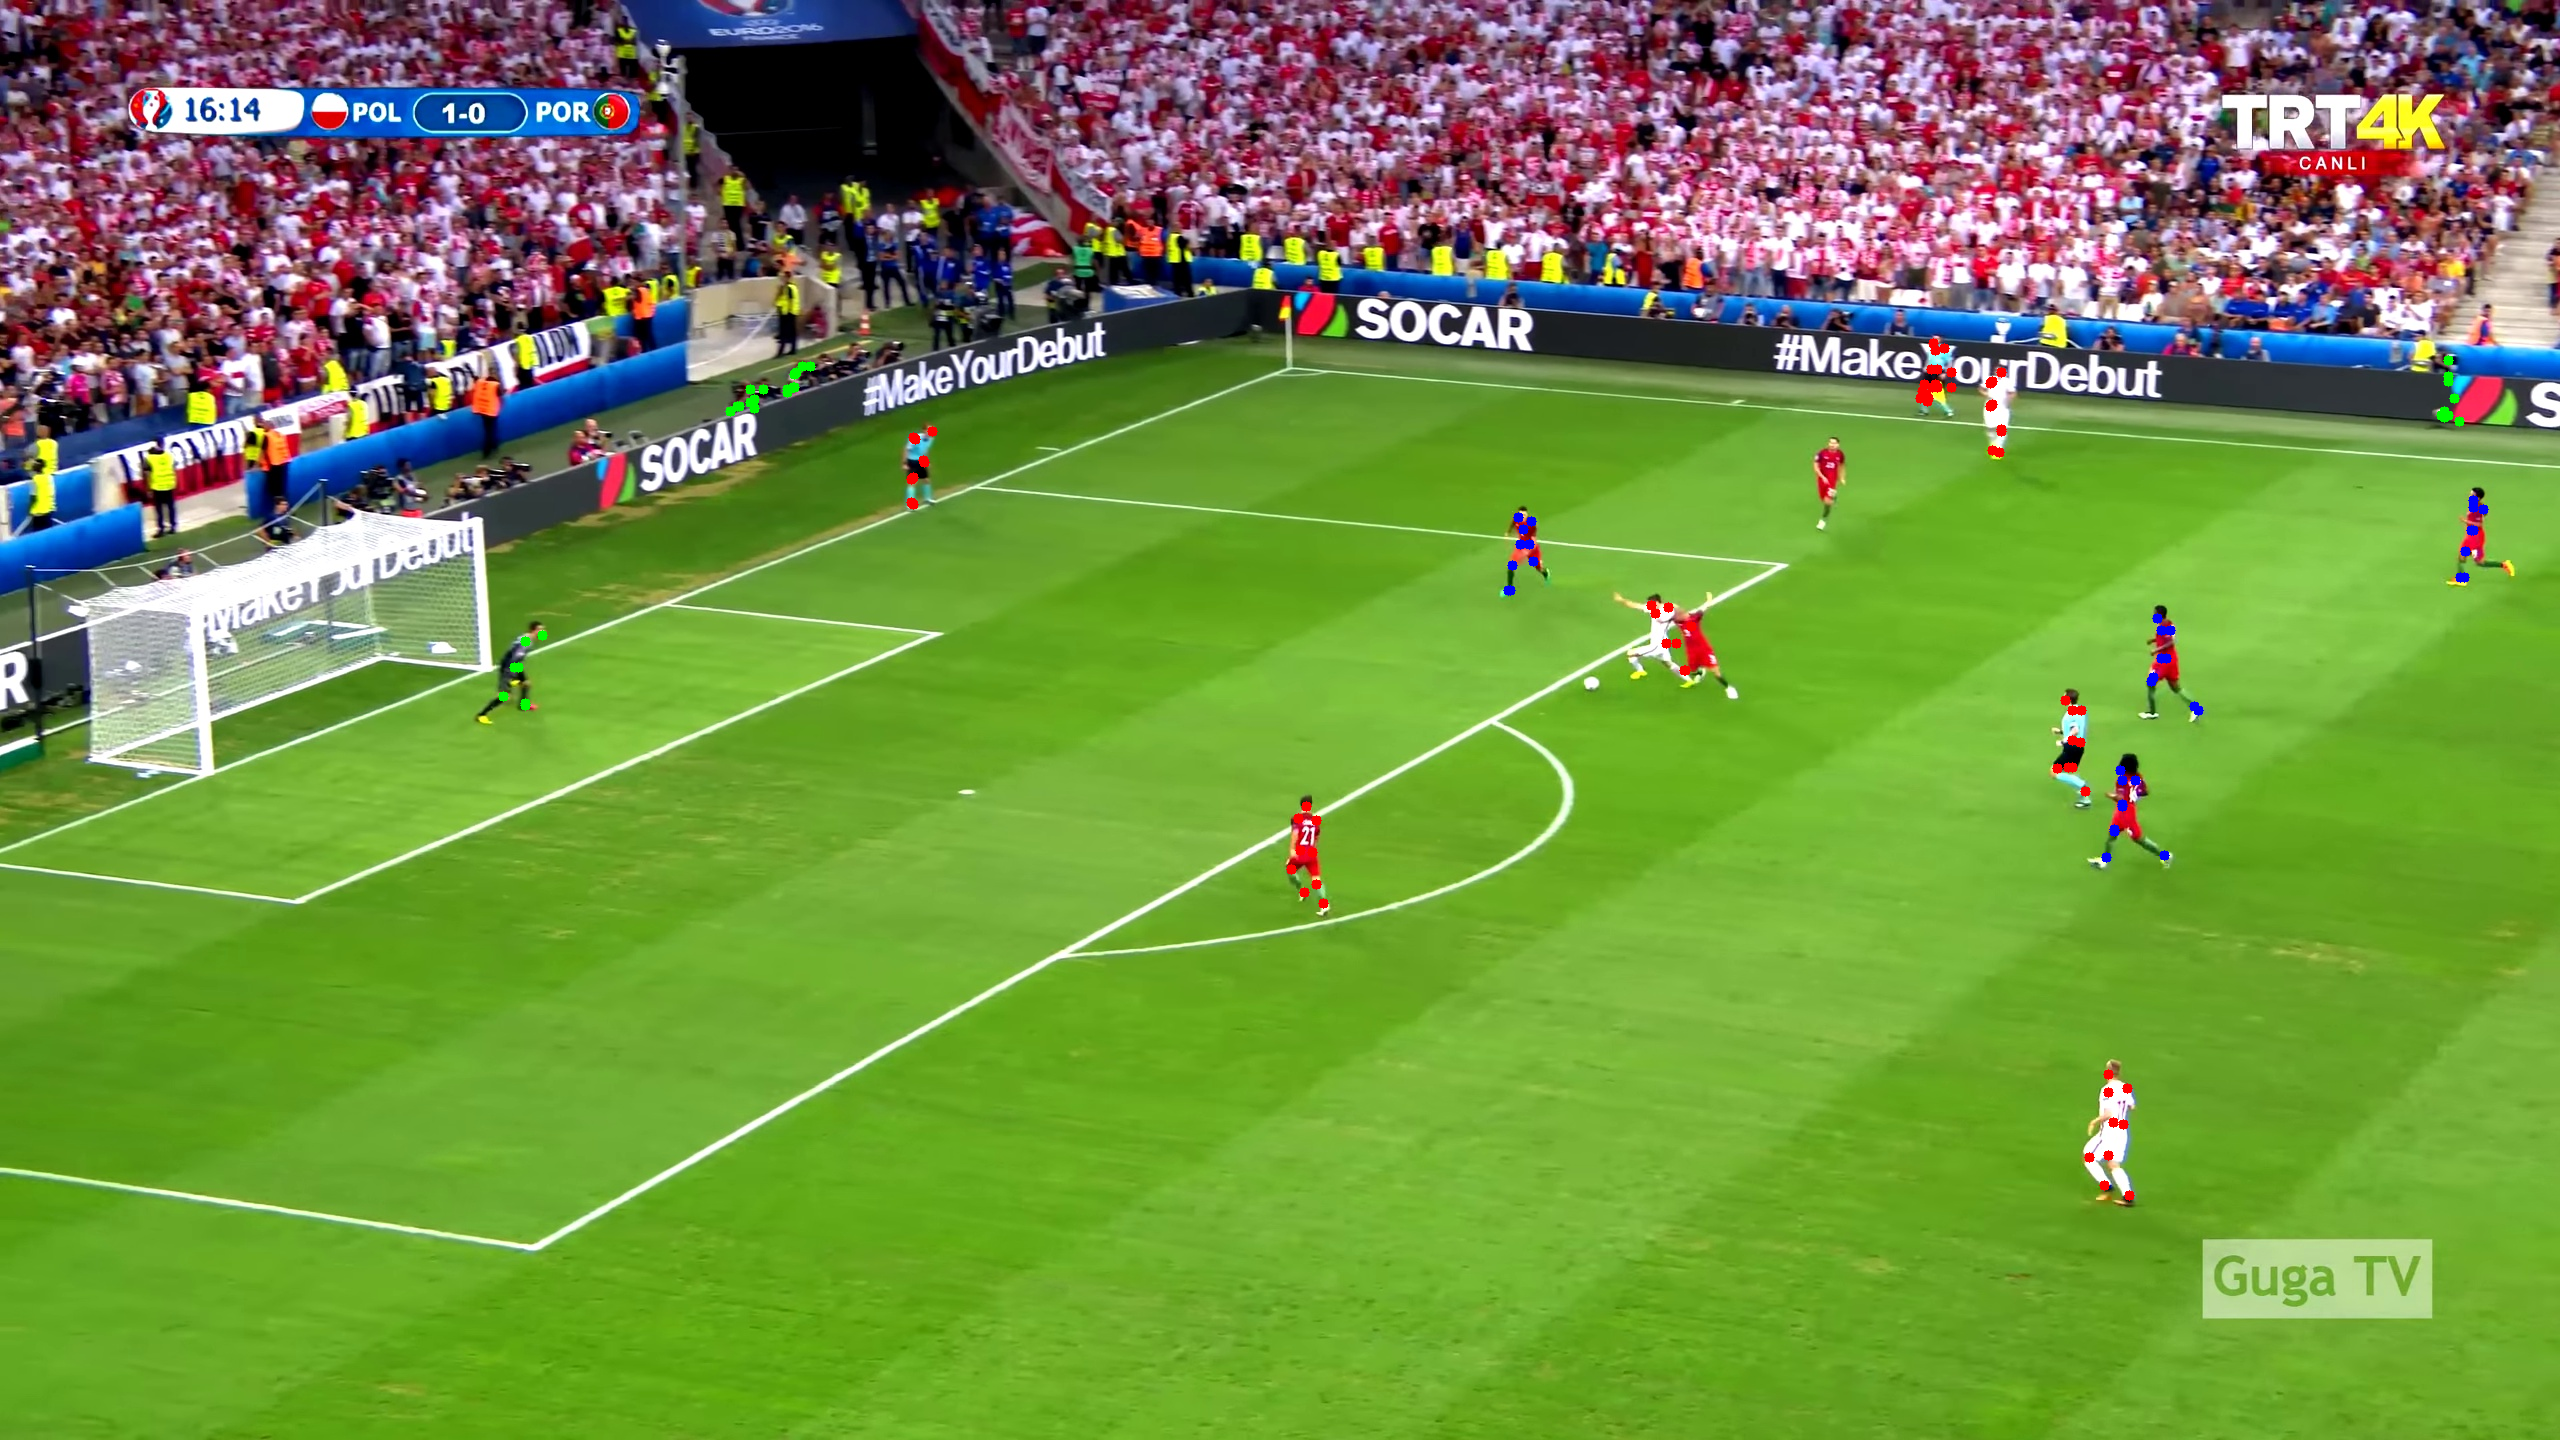

In [50]:
model = PlayersClassification()
image_info = model.get_image_info(image_path)
image_with_keypoints = model.get_image(image_info)
cv2_imshow(image_with_keypoints)

In [51]:
import pprint
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(image_info)

{ 'file_name': './images/1.jpg',
  'players': [ { 'keypoints': [ [2107.644775390625, 1074.35400390625],
                                [2107.644775390625, 1091.5484619140625],
                                [2113.369873046875, 1122.116455078125],
                                [2107.644775390625, 1154.594970703125],
                                [2128.63623046875, 1194.7154541015625],
                                [2103.828369140625, 1185.162841796875],
                                [2088.561767578125, 1156.5054931640625],
                                [2122.9111328125, 1124.0269775390625],
                                [2126.72802734375, 1087.7274169921875]],
                 'player_id': 0,
                 'team': 'GK'},
               { 'keypoints': [ [2157.058837890625, 618.12255859375],
                                [2160.7880859375, 629.5499877929688],
                                [2166.38232421875, 658.1185302734375],
                                [2153.3295

In [52]:
class SoccerFieldLineDetector:
    def __init__(self, image_path):
        self.image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        self.convergence_point = None

    def get_convergence_point(self):
        def line_intersection(line1, line2):
            rho1, theta1 = line1
            rho2, theta2 = line2
            A = np.array([
                [np.cos(theta1), np.sin(theta1)],
                [np.cos(theta2), np.sin(theta2)]
            ])
            b = np.array([[rho1], [rho2]])
            x0, y0 = np.linalg.solve(A, b)
            return [int(np.round(x0)), int(np.round(y0))]

        def find_convergence_point(intersections):
            def cost_function(point):
                return sum((point[0] - x)**2 + (point[1] - y)**2 for x, y in intersections)

            initial_guess = [0, 0]  # Pode ser ajustado com base na imagem
            result = minimize(cost_function, initial_guess, method='Powell')
            return result.x

        hsv = cv2.cvtColor(self.image, cv2.COLOR_BGR2HSV)
        lower_white = np.array([0, 0, 160])
        upper_white = np.array([180, 55, 255])
        mask = cv2.inRange(hsv, lower_white, upper_white)

        kernel_size = 3
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        mask_dilated = cv2.dilate(mask, kernel, iterations=1)
        mask_closed = cv2.morphologyEx(mask_dilated, cv2.MORPH_CLOSE, kernel)

        lines = cv2.HoughLines(mask_closed, 1, np.pi / 180, 350)
        filtered_lines = []

        if lines is not None:
            for line in lines:
                rho, theta = line[0]
                if not (abs(theta) < 0.15 or abs(theta - np.pi/2) < 0.15 or abs(theta - np.pi) < 0.15):
                    filtered_lines.append(line)

        intersections = []
        for i in range(len(filtered_lines)):
            for j in range(i+1, len(filtered_lines)):
                try:
                    intersection = line_intersection(filtered_lines[i][0], filtered_lines[j][0])
                    intersections.append(intersection)
                except np.linalg.LinAlgError:
                  pass

        if intersections:
            self.convergence_point = find_convergence_point(intersections)
            return self.convergence_point
        else:
            return None

### Identificação do ponto de fuga

O código abaixo detecta o ponto de fuga de uma determinada imagem, passo necessário para o traçado das linhas de impedimento.

In [53]:
detector = SoccerFieldLineDetector(image_path)
convergence_point = detector.get_convergence_point()
print(convergence_point)

[0. 0.]


### Traçado das linhas de impedimento

O código abaixo traça as possíveis linhas de impedimento.

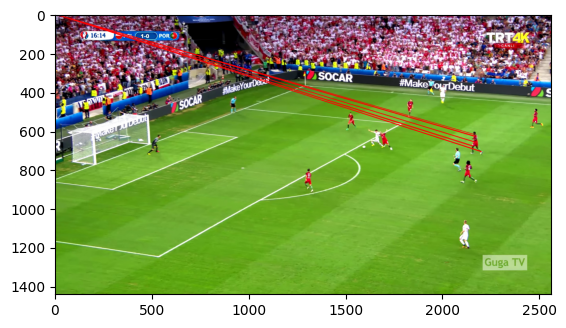

In [54]:
player = image_info['players'][1]

convergence_point = [0, 0]

for keypoint in player['keypoints']:
  cv2.line(image, (int(keypoint[0]), int(keypoint[1])), (int(convergence_point[0]), int(convergence_point[1])), (0, 0, 255), 2)


plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))